In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from math import log
#warnings.filterwarnings('ignore')

In [2]:
demographics_data = pd.read_csv(filepath_or_buffer = 'Data/demographics_data_to_use.csv')
placement_data = pd.read_csv(filepath_or_buffer = 'Data/placement_data_to_use.csv')

In [3]:
demographics_data.drop(['Ad set name','Date'], axis=1, inplace = True)

In [4]:
placement_data.drop(['Ad set name', 'Placement', 'Date'], axis=1, inplace = True)

In [5]:
less_placement = list(placement_data.columns)
less_placement.remove('Total investment')
less_demographics = list(demographics_data.columns)
less_demographics.remove('Total investment')

placement_without_new_feature = placement_data[less_placement]
demographics_without_new_feature = demographics_data[less_demographics]

In [6]:
'''
Converting age from catagorical to numeric variable
'''
demographics_data['Age'] = demographics_data['Age'].map({'65+': '65-85','18-24':'18-24',
                 '25-34':'25-34','35-44':'35-44','45-54':'45-54','55-64':'55-64',
                 '13-17':'13-17'})
low = []
high = []
for i in demographics_data['Age']:
    low.append(int(i[0:2]))
    high.append(int(i[3:5]))
demographics_data['low_age'] = low
demographics_data['high_age'] = high
demographics_data.drop(['Age'], axis=1, inplace=True)

demographics_without_new_feature['Age'] = demographics_without_new_feature['Age'].map({'65+': '65-85','18-24':'18-24',
                 '25-34':'25-34','35-44':'35-44','45-54':'45-54','55-64':'55-64',
                 '13-17':'13-17'})
low = []
high = []
for i in demographics_without_new_feature['Age']:
    low.append(int(i[0:2]))
    high.append(int(i[3:5]))
demographics_without_new_feature['low_age'] = low
demographics_without_new_feature['high_age'] = high
demographics_without_new_feature.drop(['Age'], axis=1, inplace=True)

C:\Users\zhs07\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\zhs07\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
'''
One hot encoding
'''
def one_hot(data):
    for col_name in data.columns:
        if(data[col_name].dtype == 'object'):
            one_hot = pd.get_dummies(data[col_name])
            data.drop([col_name], axis = 1, inplace = True)
            data = data.join(one_hot)
    return data

placement_without_new_feature = one_hot(placement_without_new_feature)
demographics_without_new_feature = one_hot(demographics_without_new_feature)

demographics_data = one_hot(demographics_data)
placement_data = one_hot(placement_data)

C:\Users\zhs07\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
'''
Splitting data into X,Y
'''
placement_without_Y = placement_without_new_feature['Ad revenue']
placement_without_X = placement_without_new_feature.drop('Ad revenue',axis=1)

demographics_without_Y = demographics_without_new_feature['Ad revenue']
demographics_without_X = demographics_without_new_feature.drop('Ad revenue',axis=1)

placement_Y = placement_data['Ad revenue']
placement_X = placement_data.drop('Ad revenue',axis=1)

demographics_Y = demographics_data['Ad revenue']
demographics_X = demographics_data.drop('Ad revenue',axis=1)

In [ ]:
'''
Decided not to use K-fold CV as data is temporal.
'''

In [9]:
'''
Splitting data into train,val,test
'''
placement_without_train_X = placement_without_X[:int(len(placement_without_X)*0.7)]
placement_without_val_X = placement_without_X[int(len(placement_without_X)*0.7):int(len(placement_without_X)*0.85)]
placement_without_test_X = placement_without_X[int(len(placement_without_X)*0.85):]
placement_without_train_Y = placement_without_Y[:int(len(placement_without_Y)*0.7)]
placement_without_val_Y = placement_without_Y[int(len(placement_without_Y)*0.7):int(len(placement_without_Y)*0.85)]
placement_without_test_Y = placement_without_Y[int(len(placement_without_Y)*0.85):]

demographics_without_train_X = demographics_without_X[:int(len(demographics_without_X)*0.7)]
demographics_without_val_X = demographics_without_X[int(len(demographics_without_X)*0.7):int(len(demographics_without_X)*0.85)]
demographics_without_test_X = demographics_without_X[int(len(demographics_without_X)*0.85):]
demographics_without_train_Y = demographics_without_Y[:int(len(demographics_without_Y)*0.7)]
demographics_without_val_Y = demographics_without_Y[int(len(demographics_without_Y)*0.7):int(len(demographics_without_Y)*0.85)]
demographics_without_test_Y = demographics_without_Y[int(len(demographics_without_Y)*0.85):]

placement_train_X = placement_X[:int(len(placement_X)*0.7)]
placement_val_X = placement_X[int(len(placement_X)*0.7):int(len(placement_X)*0.85)]
placement_test_X = placement_X[int(len(placement_X)*0.85):]
placement_train_Y = placement_Y[:int(len(placement_Y)*0.7)]
placement_val_Y = placement_Y[int(len(placement_Y)*0.7):int(len(placement_Y)*0.85)]
placement_test_Y = placement_Y[int(len(placement_Y)*0.85):]

demographics_train_X = demographics_X[:int(len(demographics_X)*0.7)]
demographics_val_X = demographics_X[int(len(demographics_X)*0.7):int(len(demographics_X)*0.85)]
demographics_test_X = demographics_X[int(len(demographics_X)*0.85):]
demographics_train_Y = demographics_Y[:int(len(demographics_Y)*0.7)]
demographics_val_Y = demographics_Y[int(len(demographics_Y)*0.7):int(len(demographics_Y)*0.85)]
demographics_test_Y = demographics_Y[int(len(demographics_Y)*0.85):]

In [10]:
'''
Finds RMSE
'''
def RMSE(y_predicted,y):
    n = len(y_predicted)
    diff = [m - n for m,n in zip(y_predicted,y)]
    diff = [x**2 for x in diff]
    diff = sum(diff)
    diff = diff/n
    diff = diff**0.5
    return diff

In [11]:
'''
No penalty regression to test difference between datasets
'''
'''
Since here no validation is required, we use validation as testing set.
'''
from sklearn.linear_model import LinearRegression

Model = LinearRegression()

Placement_without_model = Model.fit(placement_without_train_X,placement_without_train_Y)
print('Placement without model R^2: '+str(Placement_without_model.score(placement_without_train_X,placement_without_train_Y)))

Demographics_without_model = Model.fit(demographics_without_train_X,demographics_without_train_Y)
print('Demographics without model R^2: '+str(Demographics_without_model.score(demographics_without_train_X,demographics_without_train_Y)))

print()

Placement_model = Model.fit(placement_train_X,placement_train_Y)
print('Placement model R^2: '+str(Placement_model.score(placement_train_X,placement_train_Y)))
Demographics_model = Model.fit(demographics_train_X,demographics_train_Y)
print('Demographics model R^2: '+str(Demographics_model.score(demographics_train_X,demographics_train_Y)))

Placement without model R^2: 0.2740655349759443
Demographics without model R^2: 0.17572327391245623

Placement model R^2: 0.3158731588942779
Demographics model R^2: 0.1767696469615213


In [ ]:
'''
We can conclude that the feature added improves predictions. Thus, we shall use it.
'''

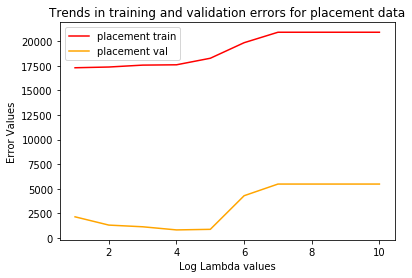

best placement lasso rmse: 804.4208754557318
best demographics lasso rmse: 11611.273957138816


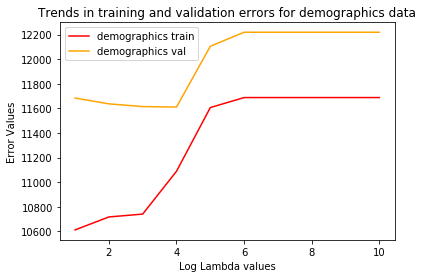

In [12]:
'''
Test lasso regression
'''
from sklearn.linear_model import Lasso

placement_train_rmse_list = []
placement_val_rmse_list = []
demographics_train_rmse_list = []
demographics_val_rmse_list = []

lambda_list = [10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000]

best_placement_lasso_model = None
best_placement_lasso_R_sq = -float('Inf')
best_placement_lasso_rmse = float('Inf')

best_demographics_lasso_model = None
best_demographics_lasso_R_sq = -float('Inf')
best_demographics_lasso_rmse = float('Inf')

for l in lambda_list:
    Lasso_Model = Lasso(alpha=l,max_iter = 100000)
    
    Lasso_Model.fit(placement_train_X,placement_train_Y)
    current_placement_R_sq = Lasso_Model.score(placement_train_X,placement_train_Y)
    current_placement_train_rmse = RMSE(Lasso_Model.predict(placement_train_X),placement_train_Y)
    current_placement_val_rmse = RMSE(Lasso_Model.predict(placement_val_X),placement_val_Y)
    placement_train_rmse_list.append(current_placement_train_rmse)
    placement_val_rmse_list.append(current_placement_val_rmse)
    
    if current_placement_val_rmse < best_placement_lasso_rmse:
        best_placement_lasso_model = Lasso_Model
        best_placement_lasso_R_sq = current_placement_R_sq
        best_placement_lasso_rmse = current_placement_val_rmse
    
    Lasso_Model.fit(demographics_train_X,demographics_train_Y)
    current_demographics_R_sq = Lasso_Model.score(demographics_train_X,demographics_train_Y)
    current_demographics_train_rmse = RMSE(Lasso_Model.predict(demographics_train_X),demographics_train_Y)
    current_demographics_val_rmse = RMSE(Lasso_Model.predict(demographics_val_X),demographics_val_Y)
    demographics_train_rmse_list.append(current_demographics_train_rmse)
    demographics_val_rmse_list.append(current_demographics_val_rmse)
    
    if current_demographics_val_rmse < best_demographics_lasso_rmse:
        best_demographics_lasso_model = Lasso_Model
        best_demographics_lasso_R_sq = current_demographics_R_sq
        best_demographics_lasso_rmse = current_demographics_val_rmse
        
lambda_list = [log(x,10) for x in lambda_list]
plt.plot(lambda_list,placement_train_rmse_list,label = 'placement train',color = 'red')
plt.plot(lambda_list,placement_val_rmse_list,label = 'placement val', color = 'orange')
plt.xlabel('Log Lambda values')
plt.ylabel('Error Values')
plt.title('Trends in training and validation errors for placement data')
plt.legend(loc='upper left')
plt.show()
print('best placement lasso rmse: ' + str(best_placement_lasso_rmse))
print('best demographics lasso rmse: ' + str(best_demographics_lasso_rmse))
plt.figure()
plt.plot(lambda_list,demographics_train_rmse_list,label = 'demographics train',color = 'red')
plt.plot(lambda_list,demographics_val_rmse_list,label = 'demographics val', color = 'orange')
plt.xlabel('Log Lambda values')
plt.ylabel('Error Values')
plt.title('Trends in training and validation errors for demographics data')
plt.legend(loc='upper left')
plt.show()

In [14]:
best_placement_lasso_model

Lasso(alpha=10000, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

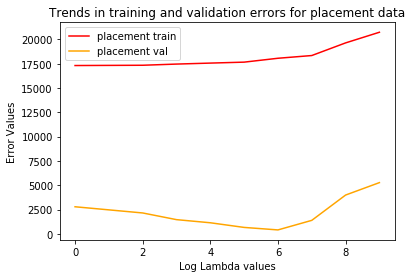

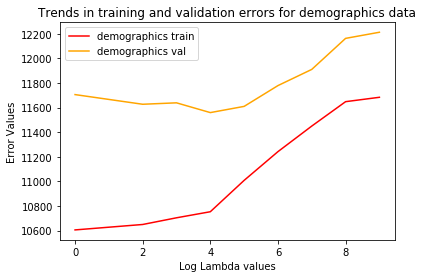

best placement ridge rmse: 408.7801324475013
best demographics ridge rmse: 11559.54490341586


In [15]:
'''
Test ridge regression
'''
from sklearn.linear_model import Ridge

placement_train_rmse_list = []
placement_val_rmse_list = []
demographics_train_rmse_list = []
demographics_val_rmse_list = []

lambda_list = [1,100,1000,10000,100000,1000000,10000000,100000000,1000000000]

best_ridge_lasso_model = None
best_placement_ridge_R_sq = -float('Inf')
best_placement_ridge_rmse = float('Inf')

best_demographics_ridge_model = None
best_demographics_ridge_R_sq = -float('Inf')
best_demographics_ridge_rmse = float('Inf')

for l in lambda_list:
    Ridge_Model = Ridge(alpha=l,max_iter = 100000)
    
    Ridge_Model.fit(placement_train_X,placement_train_Y)
    current_placement_R_sq = Ridge_Model.score(placement_train_X,placement_train_Y)
    current_placement_train_rmse = RMSE(Ridge_Model.predict(placement_train_X),placement_train_Y)
    current_placement_val_rmse = RMSE(Ridge_Model.predict(placement_val_X),placement_val_Y)
    placement_train_rmse_list.append(current_placement_train_rmse)
    placement_val_rmse_list.append(current_placement_val_rmse)
    
    if current_placement_val_rmse < best_placement_ridge_rmse:
        best_placement_ridge_model = Ridge_Model
        best_placement_ridge_R_sq = current_placement_R_sq
        best_placement_ridge_rmse = current_placement_val_rmse
    
    Ridge_Model.fit(demographics_train_X,demographics_train_Y)
    current_demographics_R_sq = Ridge_Model.score(demographics_train_X,demographics_train_Y)
    current_demographics_train_rmse = RMSE(Ridge_Model.predict(demographics_train_X),demographics_train_Y)
    current_demographics_val_rmse = RMSE(Ridge_Model.predict(demographics_val_X),demographics_val_Y)
    demographics_train_rmse_list.append(current_demographics_train_rmse)
    demographics_val_rmse_list.append(current_demographics_val_rmse)
    
    if current_demographics_val_rmse < best_demographics_ridge_rmse:
        best_demographics_ridge_model = Ridge_Model
        best_demographics_ridge_R_sq = current_demographics_R_sq
        best_demographics_ridge_rmse = current_demographics_val_rmse
        
lambda_list = [log(x,10) for x in lambda_list]
plt.plot(lambda_list,placement_train_rmse_list,label = 'placement train',color = 'red')
plt.plot(lambda_list,placement_val_rmse_list,label = 'placement val', color = 'orange')
plt.xlabel('Log Lambda values')
plt.ylabel('Error Values')
plt.title('Trends in training and validation errors for placement data')
plt.legend(loc='upper left')
plt.show()
plt.figure()
plt.plot(lambda_list,demographics_train_rmse_list,label = 'demographics train',color = 'red')
plt.plot(lambda_list,demographics_val_rmse_list,label = 'demographics val', color = 'orange')
plt.xlabel('Log Lambda values')
plt.ylabel('Error Values')
plt.title('Trends in training and validation errors for demographics data')
plt.legend(loc='upper left')
plt.show()
print('best placement ridge rmse: ' + str(best_placement_ridge_rmse))
print('best demographics ridge rmse: ' + str(best_demographics_ridge_rmse))

In [18]:
best_placement_ridge_model

Ridge(alpha=1000000, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, random_state=None, solver='auto', tol=0.001)

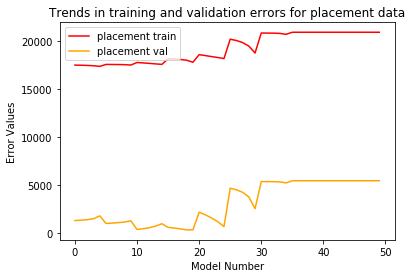

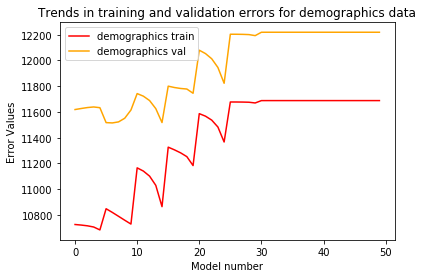

best placement Elastic Net rmse: 356.8582278583902
best demographics Elastic Net rmse: 11514.83827710379


In [21]:
'''
Test elastic nets
'''
from sklearn.linear_model import ElasticNet

placement_train_rmse_list = []
placement_val_rmse_list = []
demographics_train_rmse_list = []
demographics_val_rmse_list = []

lambda_list = [1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000]
l1_ratio_list = [0.1,0.3,0.5,0.7,0.9]

best_net_lasso_model = None
best_placement_net_R_sq = -float('Inf')
best_placement_net_rmse = float('Inf')

best_demographics_net_model = None
best_demographics_net_R_sq = -float('Inf')
best_demographics_net_rmse = float('Inf')

for l in lambda_list:
    for ratio in l1_ratio_list:
        Net_Model = ElasticNet(alpha=l,l1_ratio = ratio,max_iter = 100000)

        Net_Model.fit(placement_train_X,placement_train_Y)
        current_placement_R_sq = Net_Model.score(placement_train_X,placement_train_Y)
        current_placement_train_rmse = RMSE(Net_Model.predict(placement_train_X),placement_train_Y)
        current_placement_val_rmse = RMSE(Net_Model.predict(placement_val_X),placement_val_Y)
        placement_train_rmse_list.append(current_placement_train_rmse)
        placement_val_rmse_list.append(current_placement_val_rmse)

        if current_placement_val_rmse < best_placement_net_rmse:
            best_placement_net_model = Net_Model
            best_placement_net_R_sq = current_placement_R_sq
            best_placement_net_rmse = current_placement_val_rmse

        Net_Model.fit(demographics_train_X,demographics_train_Y)
        current_demographics_R_sq = Net_Model.score(demographics_train_X,demographics_train_Y)
        current_demographics_train_rmse = RMSE(Net_Model.predict(demographics_train_X),demographics_train_Y)
        current_demographics_val_rmse = RMSE(Net_Model.predict(demographics_val_X),demographics_val_Y)
        demographics_train_rmse_list.append(current_demographics_train_rmse)
        demographics_val_rmse_list.append(current_demographics_val_rmse)

        if current_demographics_val_rmse < best_demographics_net_rmse:
            best_demographics_net_model = Net_Model
            best_demographics_net_R_sq = current_demographics_R_sq
            best_demographics_net_rmse = current_demographics_val_rmse
            
lambda_list = [log(x,10) for x in lambda_list]
plt.plot(list(range(0,len(placement_train_rmse_list))),placement_train_rmse_list,label = 'placement train',color = 'red')
plt.plot(list(range(0,len(placement_train_rmse_list))),placement_val_rmse_list,label = 'placement val', color = 'orange')
plt.xlabel('Model Number')
plt.ylabel('Error Values')
plt.title('Trends in training and validation errors for placement data')
plt.legend(loc='upper left')
plt.show()
plt.figure()
plt.plot(list(range(0,len(placement_train_rmse_list))),demographics_train_rmse_list,label = 'demographics train',color = 'red')
plt.plot(list(range(0,len(placement_train_rmse_list))),demographics_val_rmse_list,label = 'demographics val', color = 'orange')
plt.xlabel('Model number')
plt.ylabel('Error Values')
plt.title('Trends in training and validation errors for demographics data')
plt.legend(loc='upper left')
plt.show()
print('best placement Elastic Net rmse: ' + str(best_placement_net_rmse))
print('best demographics Elastic Net rmse: ' + str(best_demographics_net_rmse))

In [22]:
best_demographics_net_model

ElasticNet(alpha=10, copy_X=True, fit_intercept=True, l1_ratio=0.3,
      max_iter=100000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
'''
Decided against using KNN and Kernel regression as the data is temporal and KNN might use 
future data to predict past results which doesn't make sense
'''

In [ ]:
'''
Conclusion:
'''

'''
Elastic net works the best with lambda = 100, l1_ratio = 0.9
'''